## Автоматическое определение туберкулеза по флюорографии

**Норма**|**Патология**
---|---
![X-Ray Normal](https://www.dropbox.com/s/b5nk171zefpb55m/normal.png?dl=1) | ![X-Ray Tuberculesis](https://www.dropbox.com/s/1t2mko52jjignhu/tuberculosis.png?dl=1)

Для обучения использован открыты набор данных [Pulmonary Chest X-Ray Abnormalities](https://www.kaggle.com/kmader/pulmonary-chest-xray-abnormalities/home) на Kaggle. Исходные изображения были преобразованы к размеру 299х299 и распределены в каталоги по классам, как требует Keras. Ссылка на преобразованные изображения - https://www.dropbox.com/s/f64cvlhm0gp80v5/tuberculosis.zip?dl=1

Используется сеть Google InceptionV3, а также дополнение данных.

При запуске желательно подключить GPU (меню Runtime -> Change runtime type -> Hardware Accelerator -> GPU), иначе сеть будет очень долго обучаться.

In [1]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Размер изображения
image_size = 299
# Размер мини-выборки
batch_size = 32

## Генераторы изображений

In [3]:
# Каталог с данными для обучения
train_dir = 'Datasets/train'
test_dir = 'Datasets/val'
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (image_size, image_size, 3)

Деректерді толықтыру (data augmentation)

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest')

Проверяем генератор

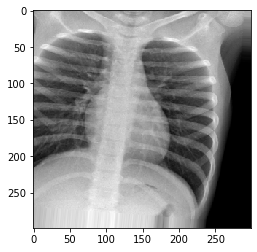

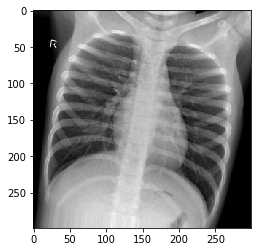

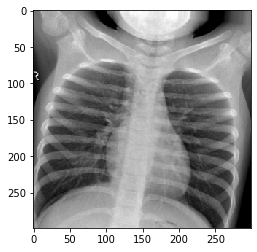

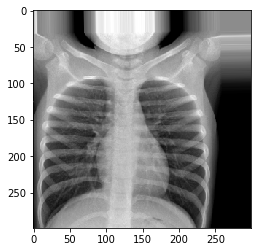

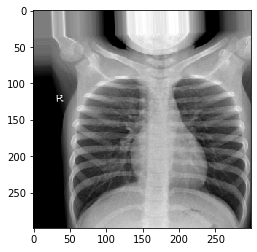

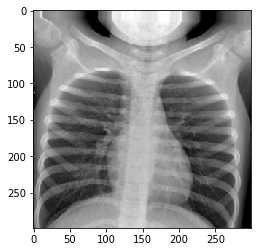

In [5]:
img_path = 'Datasets/train/NORMAL/NORMAL2-IM-0516-0001.jpeg'
img = image.load_img(img_path, target_size=(image_size, image_size))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 6 == 0:
        break
plt.show()

Генератор для обучения

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')

Found 6029 images belonging to 2 classes.


Генератор для тестирования без дополнения данных

In [7]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [8]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')

Found 400 images belonging to 2 classes.


Номера классов в генераторах

In [9]:
train_generator.class_indices

{'Normal': 0, 'Tuberculosis': 1}

## Загружаем предварительно обученную нейронную сеть Inception

In [10]:
pretrained_model = InceptionV3(weights = 'imagenet',include_top = False)

In [11]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

"Замораживаем" веса предварительно обученной нейронной сети

In [12]:
pretrained_model.trainable = False

## Создаем составную нейронную сеть

In [13]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

## Обучаем составную нейронную сеть на основе InceptionV3

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4), 
              metrics=['accuracy'])

In [33]:
filepath="inceptionv3_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

In [95]:
steps_per_epoch = 40
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=20,
    verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 40 steps, validate for 5 steps
Epoch 1/20

Epoch 00001: val_accuracy improved from -inf to 0.64375, saving model to inceptionv3_best.h5
40/40 - 376s - loss: 0.2487 - accuracy: 0.9047 - val_loss: 0.5655 - val_accuracy: 0.6438
Epoch 2/20

Epoch 00002: val_accuracy did not improve from 0.64375
40/40 - 1147s - loss: 0.1094 - accuracy: 0.9719 - val_loss: 0.5821 - val_accuracy: 0.6313
Epoch 3/20

Epoch 00003: val_accuracy improved from 0.64375 to 0.65000, saving model to inceptionv3_best.h5
40/40 - 304s - loss: 0.0772 - accuracy: 0.9742 - val_loss: 0.6092 - val_accuracy: 0.6500
Epoch 4/20

Epoch 00004: val_accuracy did not improve from 0.65000
40/40 - 269s - loss: 0.0455 - accuracy: 0.9922 - val_loss: 0.6684 - val_accuracy: 0.6313
Epoch 5/20

Epoch 00005: val_accuracy did not improve from 0.65000
40/40 - 294s - loss: 0.0309 - accuracy: 0.9937 - val_loss: 1.0

## Дообучение сверточных слоев Inception V3

Загружаем лучшие веса

In [15]:
model.load_weights("inceptionv3_best.h5")

Размораживаем два последних блока Inception

In [16]:
pretrained_model.trainable = False
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

Компилируем сеть с размороженными слоями

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4), 
              metrics=['accuracy'])

In [37]:
filepath="inceptionv3_fine_tuned.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, learning_rate_reduction]

In [100]:
steps_per_epoch = 40
history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=5,
    verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 40 steps, validate for 5 steps
Epoch 1/5

Epoch 00001: val_accuracy improved from -inf to 0.88125, saving model to inceptionv3_fine_tuned.h5
40/40 - 254s - loss: 0.0282 - accuracy: 0.9906 - val_loss: 0.2284 - val_accuracy: 0.8813
Epoch 2/5

Epoch 00002: val_accuracy improved from 0.88125 to 0.89375, saving model to inceptionv3_fine_tuned.h5
40/40 - 220s - loss: 0.0125 - accuracy: 0.9953 - val_loss: 0.2012 - val_accuracy: 0.8938
Epoch 3/5

Epoch 00003: val_accuracy did not improve from 0.89375
40/40 - 221s - loss: 0.0192 - accuracy: 0.9945 - val_loss: 0.4341 - val_accuracy: 0.7750
Epoch 4/5

Epoch 00004: val_accuracy did not improve from 0.89375
40/40 - 221s - loss: 0.0058 - accuracy: 0.9984 - val_loss: 0.3673 - val_accuracy: 0.8375
Epoch 5/5

Epoch 00005: val_accuracy did not improve from 0.89375

Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
40/40 - 220s - loss: 0.0015 - accuracy: 1.0000 - va

## Тестируем модель

Загружаем обученные веса

In [18]:
model = load_model("inceptionv3_fine_tuned.h5")

Загружаем изображение

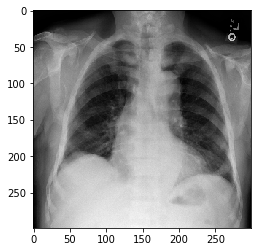

In [32]:
#img_path = 'Datasets/val/Normal/IM-0110-0001.jpeg'
img_path = 'Datasets/test/Tuberculosis/00000011_000.png'
img = image.load_img(img_path, target_size=(image_size, image_size))
plt.imshow(img)
plt.show()

Преобразуем изображение в массив для распознавания

In [33]:
x = image.img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

Запускаем распознавание

In [34]:
prediction = model.predict(x)

In [35]:
prediction

array([[0.8511419]], dtype=float32)

In [37]:
if prediction[[0]] < 0.5:
    print('Normal')
else:
    print('Tuberculosis')

Tuberculosis


In [44]:
from sklearn.externals import joblib

C:\Users\Meirman\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [49]:
joblib.dump(model, "modelWithoutImg.pkl")

['modelWithoutImg.pkl']

In [46]:
import pickle

In [47]:
pickle.dump(model, open('models/final_prediction.pkl', 'wb'))

In [48]:
model.save('Xray_model', save_format='pkl' )

AttributeError: 'str' object has no attribute 'save'

In [40]:
#from multiprocessing import Queue

In [41]:
#import pickle, pickletools, _thread

In [42]:
#lock = _thread.RLock()

In [43]:
#lock

In [74]:
#md = pickle.dumps(model, protocol=0)

In [75]:
#import pickle

In [76]:
#pkl_filename = "pickle_model.pkl"
#with open(pkl_filename, 'rb') as file:
#    pickle.dump(model, 3,  file)

In [45]:
#pickle.dumps(model, pkl_filename)

In [46]:
#
#    pickle.dump(model, file)

In [55]:
#from multiprocessing import Lock
#lock = Lock()

['joblib_model.pkl']

In [66]:
#from tensorflow.keras.utils import CustomObjectScope

#with CustomObjectScope({'AttentionLayer': AttentionLayer}):
#    model = load_model('my_model.pkl')

In [87]:
#def train(config, reporter=None):
#    rnn_config = RNNconfig()
#    rnn_config.status_reporter = reporter
    